In [1]:
building_id = 0
price = 400
iteration = 0
# we are ready to run!

In [2]:
# Parameters
building_id = 3
price = 400
iteration = 4


In [3]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = 'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = 'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)



# Weather file
epw_file   = 'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = 'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [4]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
error_dir  = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(output_dir)

# EHUB
ehub_dir   = 'ehub/output_ehub_excel/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = "rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106
ga_file = ga_output_dir + "panel_{}_dual.xlsx".format(price)
ga_proc = ga_output_dir + "panel_{}_dual_processed.xlsx".format(price)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML


# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [7]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir, 
                                   epw_file=epw_file, err_dir=error_dir) 

## the North Axis
The north axis gets grabbed automatically from the idf.

In [8]:
pvbuilding.North_Axis

0.0

In [9]:
pvbuilding.Building_Information


Building,
    Ref Bldg Warehouse New2004_v1.3_5.0,    !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    40,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [10]:
# Determine the hourly electricity use
pvbuilding.run_ep()

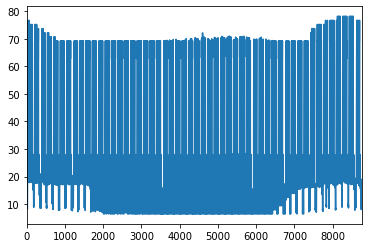

In [11]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [12]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 10,626.92
78.13965517958043


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [13]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 4,598 m²
Roof area is up 70 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [14]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.579655885696411 sec


0.0


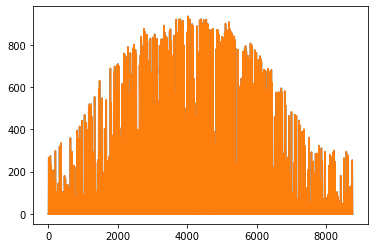

In [15]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)
Loading the model
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


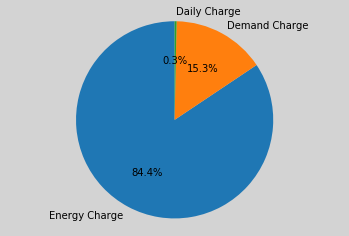

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%


In [16]:
from pv_model import pvModel
# These are the fixed five panels that we are interested in
if (number_of_panels==5):
    azi = [180,215,245,215,130]
    tilt = [35,55,10,35,5]
    gcr = [0.6,0.35,0.9,0.7,0.9]
# These are the fixed three panels that we are interested in
if (number_of_panels==3):
    azi = [180,215,245]
    tilt = [35,55,10]
    gcr = [0.9,0.35,0.9]
# Setup the values array
pan_vals = []
pan_vals.extend(azi)
pan_vals.extend(tilt)
pan_vals.extend(gcr)

pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels)
my_model.eval_model(pan_vals,400,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [17]:
my_model.roof_percentage()

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%


In [18]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    4667.576
dtype: float64

In [19]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         20723.9
Aug         22065.5
Dec         23271.5
Feb         20983.8
Jan         23774.3
Jul         19933.9
Jun         20611.8
Mar         23584.0
May         21175.7
Nov         22611.0
Oct         21919.2
Sep         20481.3
monthly_import    261135.9
dtype: float64
261136.0
     monthly_export
Apr             0.0
Aug             0.0
Dec             0.0
Feb             0.0
Jan             0.0
Jul             0.0
Jun             0.0
Mar             0.0
May             0.0
Nov             0.0
Oct             0.0
Sep             0.0
monthly_export    0.0
dtype: float64
0.0
97.5645


In [20]:
my_model.solveResults['solution']['daily_charge_c']

97.5645

In [21]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             0
PV0                  0
PV1                  0
PV2                  0

In [22]:
my_model.solveResults['solution']['any_above_35']

1

In [23]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [24]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 400}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 400}


The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 245, 215, 41, 51, 21, 0.7499999999999998, 0.7, 0.39999999999999997)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


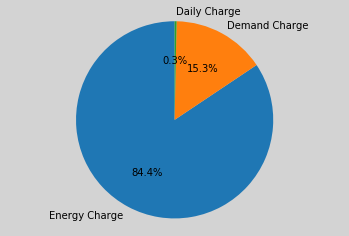

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (150, 235, 170, 16, 51, 26, 0.25, 0.7, 0.8499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 16.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8867814540863037 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 51.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.018469572067261 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


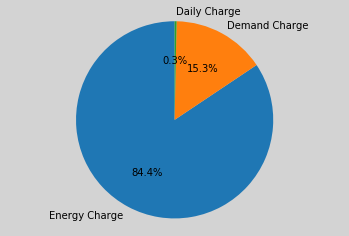

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 185, 230, 16, 16, 31, 0.8999999999999999, 0.25, 0.35)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


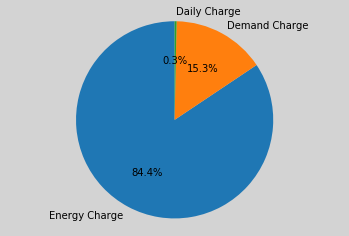

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (95, 110, 165, 31, 51, 31, 0.8999999999999999, 0.5999999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


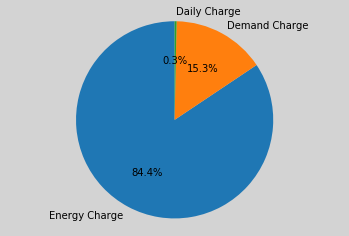

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (100, 250, 155, 16, 36, 46, 0.8999999999999999, 0.49999999999999994, 0.8499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 36.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8490912914276123 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 46.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.847287893295288 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


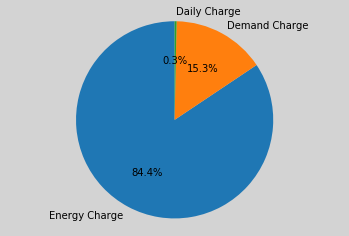

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 100, 175, 11, 26, 41, 0.35, 0.7, 0.25)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 26.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.484478712081909 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


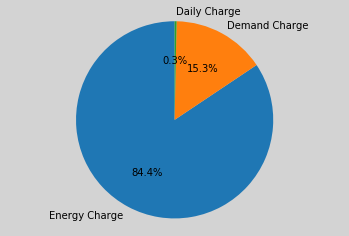

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (195, 180, 260, 26, 46, 56, 0.39999999999999997, 0.7499999999999998, 0.8999999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 56.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.189802169799805 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


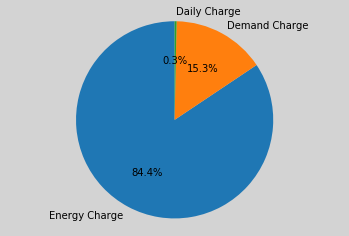

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (155, 100, 190, 31, 41, 11, 0.35, 0.7, 0.49999999999999994)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


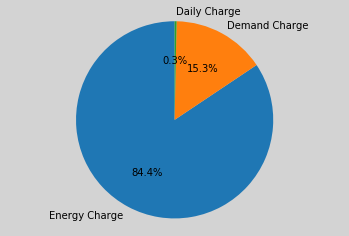

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (255, 175, 235, 31, 26, 41, 0.44999999999999996, 0.6499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 31.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.137882471084595 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8913915157318115 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


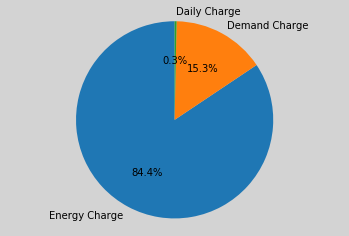

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 180, 250, 56, 36, 21, 0.5999999999999999, 0.35, 0.6499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 56.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


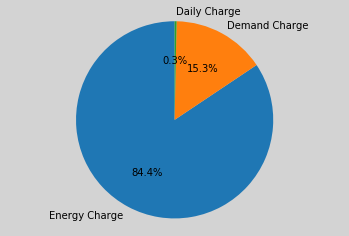

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 95, 210, 11, 6, 46, 0.5499999999999999, 0.7999999999999998, 0.8999999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 11.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.2865447998046875 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


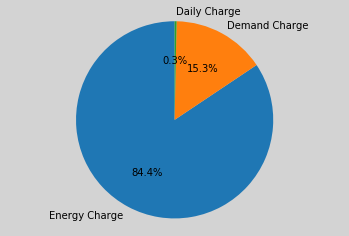

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (135, 195, 210, 6, 16, 21, 0.7999999999999998, 0.3, 0.7499999999999998)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 6.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8973302841186523 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


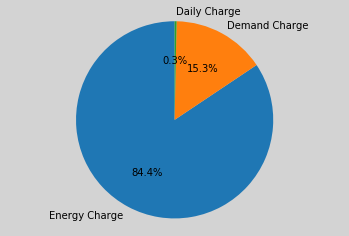

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (205, 250, 110, 16, 41, 51, 0.35, 0.7, 0.5499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


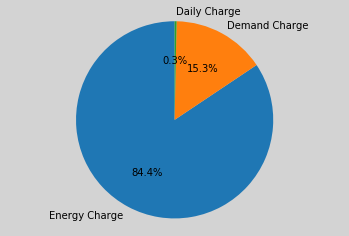

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (220, 155, 255, 26, 51, 11, 0.5499999999999999, 0.7499999999999998, 0.7)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 26.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.090605974197388 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


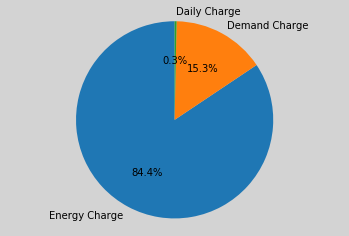

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (140, 200, 160, 51, 26, 21, 0.8999999999999999, 0.5999999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 21.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.556856155395508 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


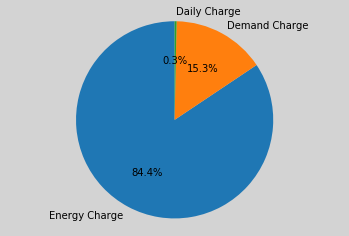

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (230, 110, 185, 6, 46, 26, 0.8499999999999999, 0.7999999999999998, 0.44999999999999996)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 46.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.129763126373291 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 26.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.105464935302734 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


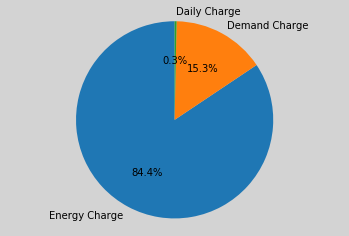

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 140, 115, 51, 6, 6, 0.3, 0.7, 0.6499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 6.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.101553440093994 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 6.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.010230302810669 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


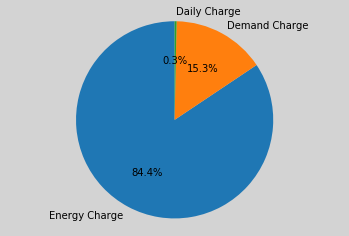

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (120, 160, 165, 21, 51, 31, 0.3, 0.7499999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 21.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 51.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9870805740356445 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


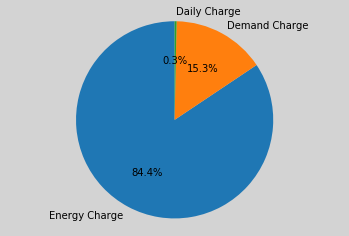

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (150, 130, 175, 21, 46, 6, 0.5999999999999999, 0.5499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 46.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.382364749908447 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


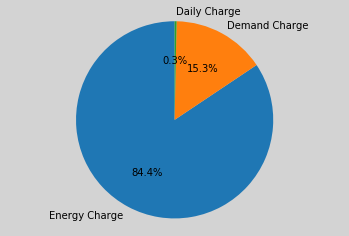

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (130, 160, 145, 11, 11, 21, 0.7499999999999998, 0.6499999999999999, 0.25)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 11.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


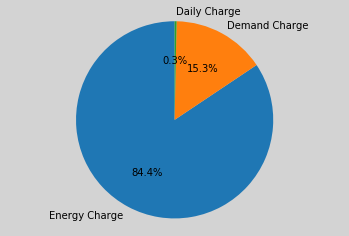

ERROR:optimizer_logger:20


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 400}


Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (130, 245, 130, 11, 51, 16, 0.35, 0.7999999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 16.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.962221384048462 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


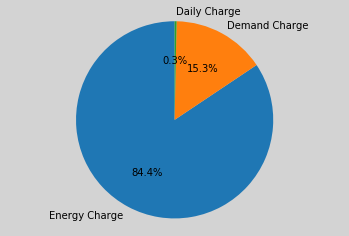

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (255, 130, 235, 46, 36, 31, 0.7, 0.8999999999999999, 0.25)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 36.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.215388298034668 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


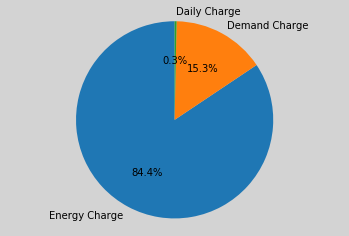

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (245, 210, 225, 1, 51, 26, 0.7499999999999998, 0.44999999999999996, 0.3)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 1.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4339382648468018 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 51.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


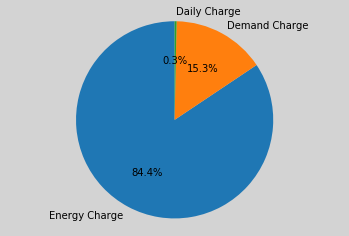

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (170, 225, 240, 16, 26, 16, 0.39999999999999997, 0.8999999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.072288274765015 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


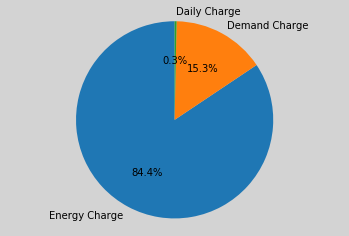

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (240, 210, 190, 56, 21, 51, 0.2, 0.39999999999999997, 0.3)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 56.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.142948150634766 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


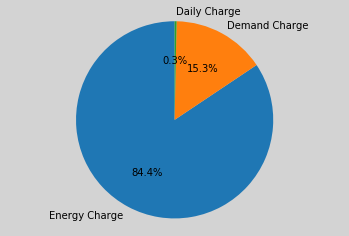

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (90, 185, 90, 56, 11, 6, 0.5999999999999999, 0.8999999999999999, 0.25)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.134915113449097 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 6.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9751317501068115 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


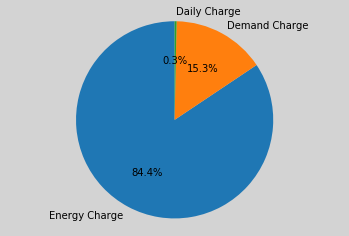

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (220, 220, 265, 56, 1, 11, 0.44999999999999996, 0.7999999999999998, 0.5499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 56.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.172027826309204 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 1.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.40032958984375 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


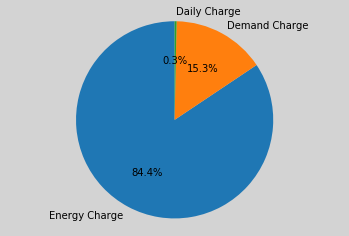

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (175, 130, 185, 16, 41, 21, 0.8999999999999999, 0.35, 0.8499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 16.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.2333362102508545 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


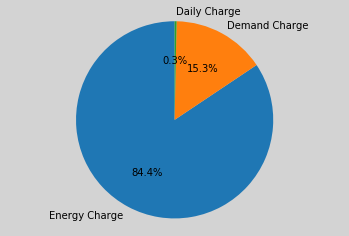

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (205, 95, 95, 6, 11, 21, 0.3, 0.25, 0.8999999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 21.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


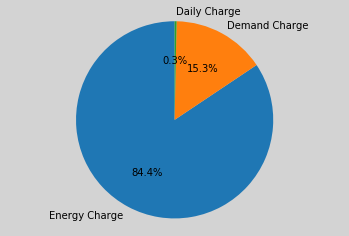

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 245, 235, 16, 56, 11, 0.44999999999999996, 0.3, 0.7499999999999998)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.199005603790283 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 56.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.154839277267456 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 11.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.3664281368255615 sec


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


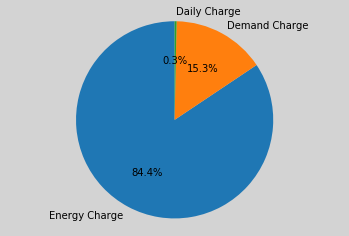

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 225, 210, 31, 21, 41, 0.8999999999999999, 0.6499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


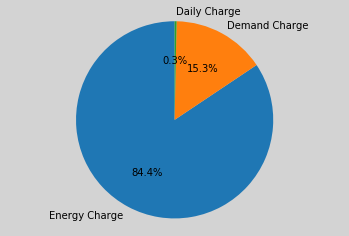

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (115, 250, 250, 11, 6, 41, 0.8999999999999999, 0.7499999999999998, 0.49999999999999994)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 41.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.28688645362854 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


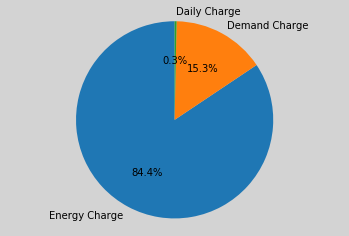

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 125, 255, 1, 21, 21, 0.5999999999999999, 0.39999999999999997, 0.7499999999999998)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


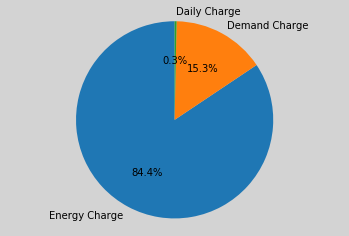

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (170, 190, 250, 46, 51, 41, 0.7499999999999998, 0.8499999999999999, 0.3)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 46.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9611661434173584 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 51.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.350795745849609 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


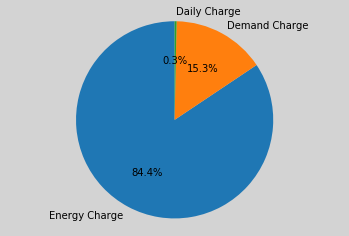

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (265, 140, 115, 51, 56, 26, 0.3, 0.3, 0.6499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 26.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.1246466636657715 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


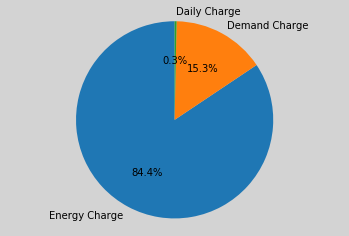

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (260, 250, 215, 26, 21, 36, 0.6499999999999999, 0.5499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 26.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 21.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


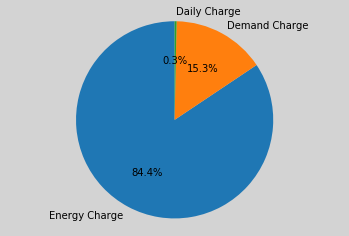

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (225, 245, 120, 1, 46, 41, 0.7499999999999998, 0.6499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 1.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5890681743621826 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


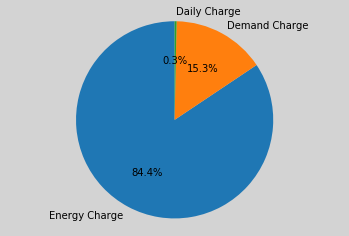

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 115, 150, 56, 6, 21, 0.3, 0.5499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.056789875030518 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


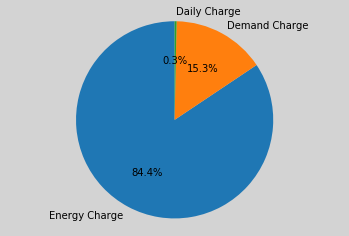

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (210, 240, 205, 26, 16, 6, 0.25, 0.2, 0.6499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 16.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 6.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


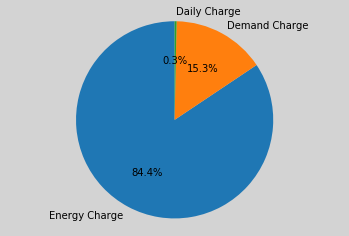

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (135, 90, 210, 16, 31, 16, 0.8499999999999999, 0.8999999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


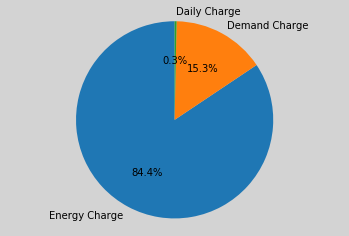

ERROR:optimizer_logger:40


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 400}


Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (225, 180, 195, 51, 46, 6, 0.7999999999999998, 0.3, 0.7)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 6.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


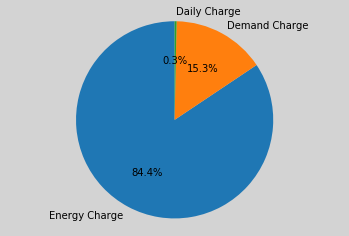

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 170, 195, 41, 31, 21, 0.35, 0.8499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 31.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.2948455810546875 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


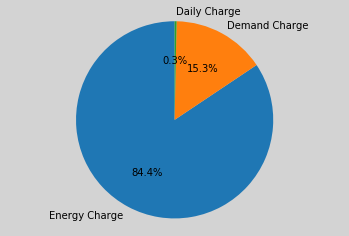

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (130, 240, 140, 36, 6, 46, 0.3, 0.39999999999999997, 0.49999999999999994)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


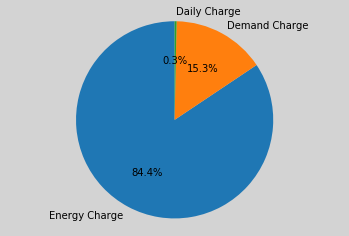

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (255, 150, 130, 26, 46, 51, 0.3, 0.39999999999999997, 0.5999999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 46.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.109629392623901 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


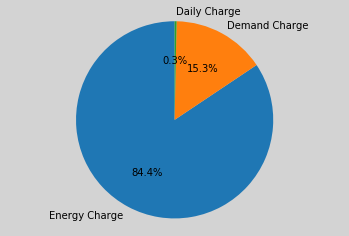

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (220, 110, 175, 11, 16, 31, 0.2, 0.39999999999999997, 0.7499999999999998)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 11.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.1791698932647705 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 31.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


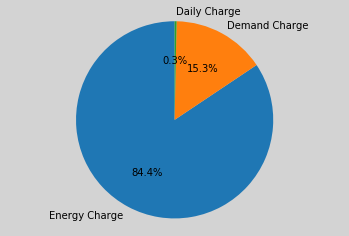

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (100, 95, 220, 31, 1, 31, 0.3, 0.3, 0.44999999999999996)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 1.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5310347080230713 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


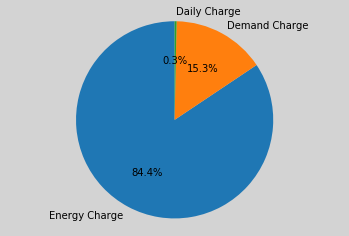

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (210, 220, 150, 1, 41, 56, 0.7999999999999998, 0.7, 0.6499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 1.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4112462997436523 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 41.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.008097171783447 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.259396076202393 sec


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


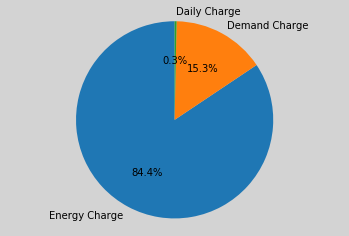

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (265, 165, 160, 51, 36, 46, 0.49999999999999994, 0.5999999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 46.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.142069578170776 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


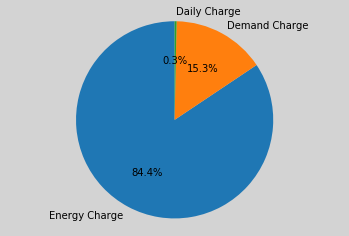

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 115, 220, 46, 51, 1, 0.7499999999999998, 0.7499999999999998, 0.8999999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 46.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.173800945281982 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


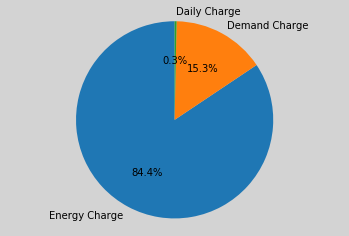

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (160, 220, 245, 21, 31, 21, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 31.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.1331470012664795 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


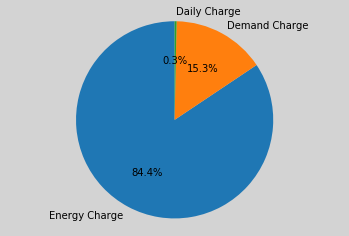

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (175, 205, 90, 6, 56, 11, 0.8499999999999999, 0.3, 0.5999999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 6.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9324910640716553 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


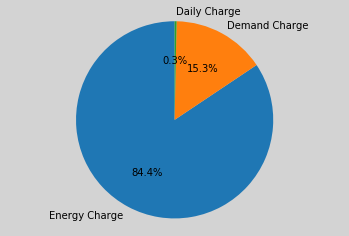

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (140, 125, 225, 21, 31, 16, 0.8999999999999999, 0.39999999999999997, 0.25)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 21.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 31.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.0922791957855225 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


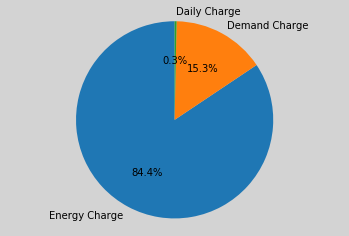

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 105, 230, 46, 46, 51, 0.7499999999999998, 0.7, 0.49999999999999994)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


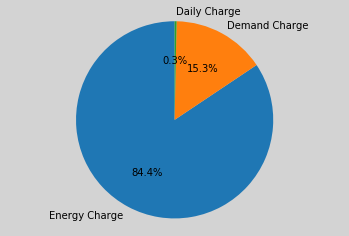

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 230, 200, 46, 31, 46, 0.2, 0.5999999999999999, 0.7)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 46.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.018206357955933 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


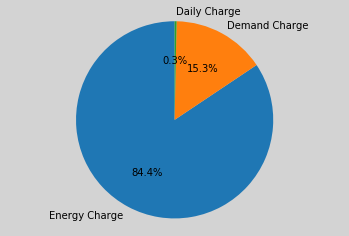

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (90, 265, 110, 36, 41, 31, 0.7999999999999998, 0.7999999999999998, 0.8499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 36.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.112418174743652 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


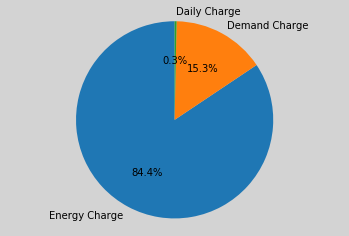

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (205, 100, 100, 46, 41, 6, 0.2, 0.35, 0.39999999999999997)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 46.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 6.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.150012254714966 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


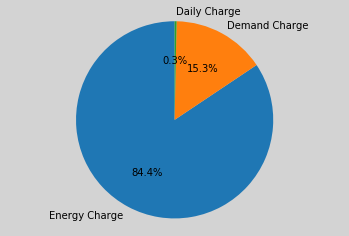

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (150, 160, 140, 6, 41, 46, 0.8999999999999999, 0.5999999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 6.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9109108448028564 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


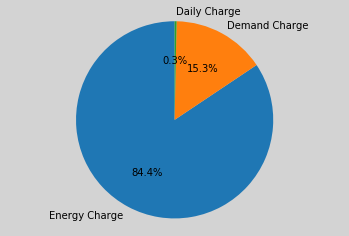

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 90, 225, 46, 26, 46, 0.35, 0.39999999999999997, 0.39999999999999997)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 46.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8983781337738037 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


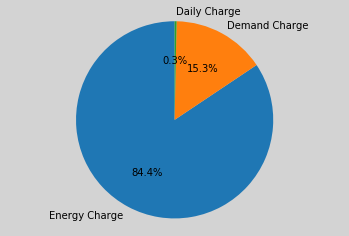

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (125, 255, 115, 36, 26, 6, 0.7999999999999998, 0.49999999999999994, 0.6499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 36.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.108595132827759 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 6.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


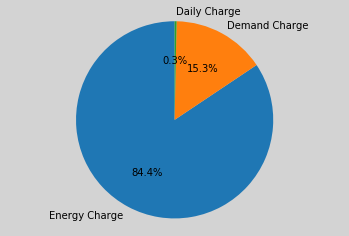

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 230, 200, 31, 46, 1, 0.5499999999999999, 0.6499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 1.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


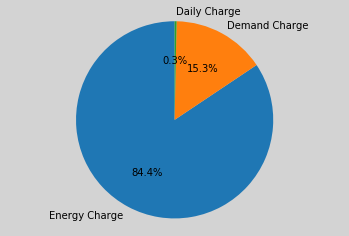

ERROR:optimizer_logger:60


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 400}


Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (265, 240, 175, 11, 36, 16, 0.7499999999999998, 0.7499999999999998, 0.2)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 11.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.363507032394409 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 36.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9405336380004883 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 16.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


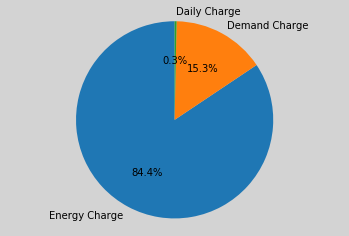

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (130, 185, 155, 56, 16, 1, 0.25, 0.3, 0.2)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 56.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.1459128856658936 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 1.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.443190574645996 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


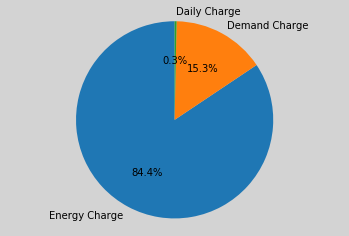

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (260, 250, 145, 31, 36, 16, 0.5499999999999999, 0.5499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 31.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.192319869995117 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 36.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.903236150741577 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


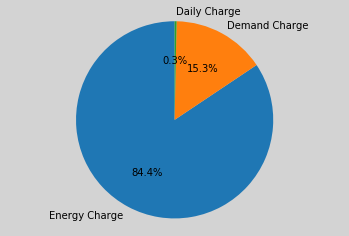

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (150, 100, 135, 46, 21, 36, 0.3, 0.6499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 46.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.912956476211548 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


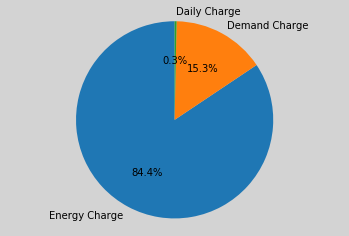

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (110, 255, 150, 11, 41, 36, 0.8999999999999999, 0.5499999999999999, 0.25)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 11.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.128403663635254 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.12988018989563 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 36.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


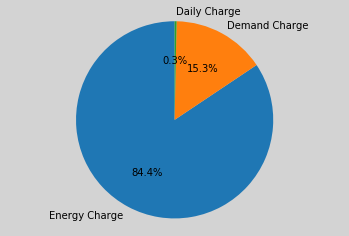

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 105, 160, 56, 36, 6, 0.6499999999999999, 0.5499999999999999, 0.2)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


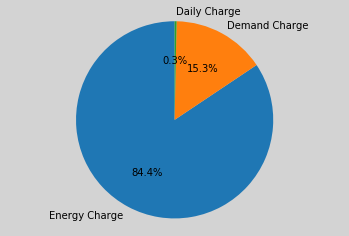

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (260, 155, 205, 11, 46, 6, 0.7999999999999998, 0.49999999999999994, 0.7)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 46.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.37479567527771 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 6.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


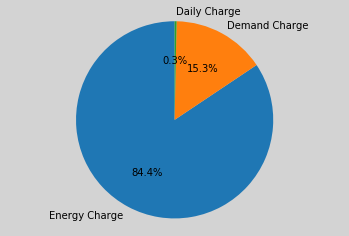

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (145, 210, 95, 11, 36, 1, 0.2, 0.44999999999999996, 0.44999999999999996)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 1.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.563281536102295 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


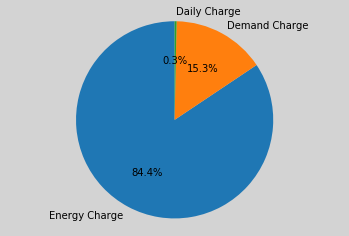

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 255, 90, 31, 36, 16, 0.44999999999999996, 0.7499999999999998, 0.7)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


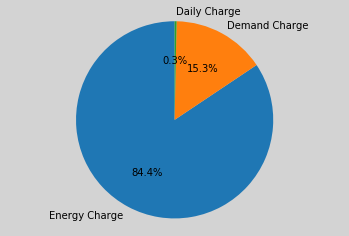

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (200, 245, 170, 16, 56, 41, 0.7999999999999998, 0.2, 0.7999999999999998)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 56.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.013535499572754 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 41.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.920313596725464 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


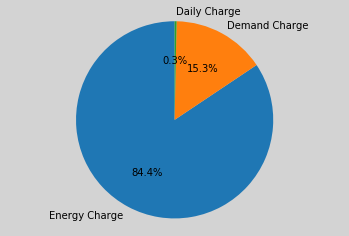

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (100, 105, 165, 11, 56, 51, 0.35, 0.44999999999999996, 0.5499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


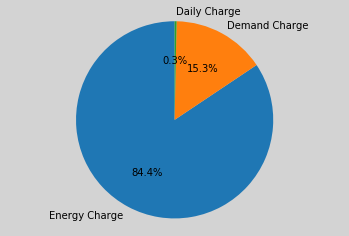

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 90, 195, 11, 46, 41, 0.6499999999999999, 0.7999999999999998, 0.7)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 11.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.627917051315308 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 46.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.553929567337036 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


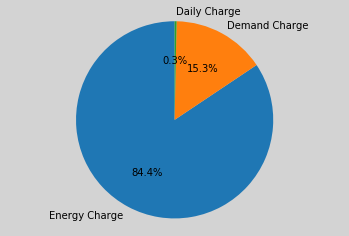

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (160, 180, 185, 16, 11, 1, 0.5999999999999999, 0.44999999999999996, 0.39999999999999997)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 1.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.601968765258789 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


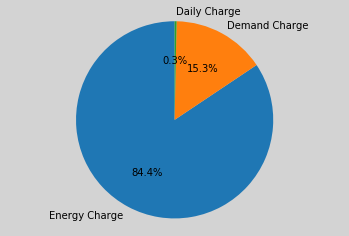

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (90, 140, 95, 11, 31, 46, 0.39999999999999997, 0.5999999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


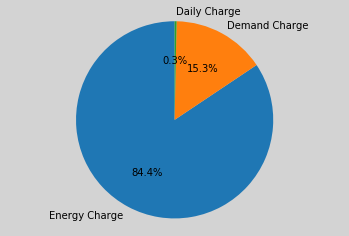

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (255, 235, 210, 26, 51, 11, 0.7499999999999998, 0.7999999999999998, 0.49999999999999994)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.10818338394165 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 51.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.0770838260650635 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


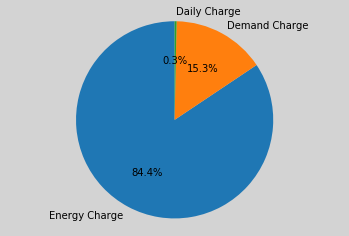

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (160, 215, 100, 6, 16, 21, 0.8999999999999999, 0.49999999999999994, 0.3)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 16.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 21.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


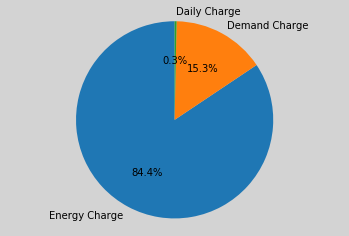

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (210, 180, 120, 16, 56, 26, 0.25, 0.39999999999999997, 0.7999999999999998)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 16.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.033420562744141 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 26.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


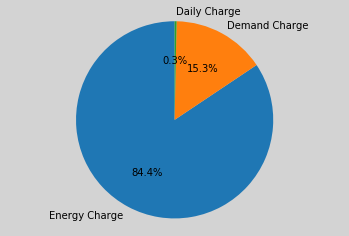

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (165, 175, 235, 16, 1, 51, 0.35, 0.35, 0.7999999999999998)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 1.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4513704776763916 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


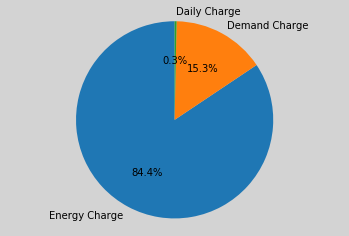

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (255, 190, 115, 41, 56, 36, 0.7999999999999998, 0.25, 0.7999999999999998)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.103530406951904 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 56.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.077905654907227 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


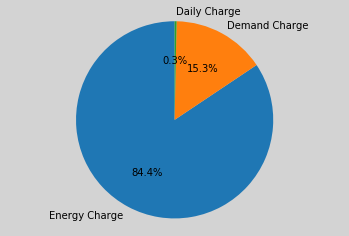

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (245, 260, 145, 46, 31, 11, 0.7999999999999998, 0.25, 0.8999999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


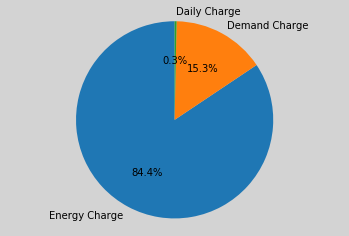

ERROR:optimizer_logger:80


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 400}


Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (245, 180, 215, 41, 56, 1, 0.5499999999999999, 0.8999999999999999, 0.7)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5145061016082764 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


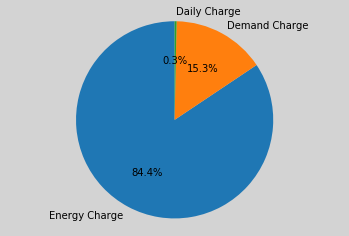

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (135, 175, 195, 41, 36, 16, 0.2, 0.5999999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 41.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


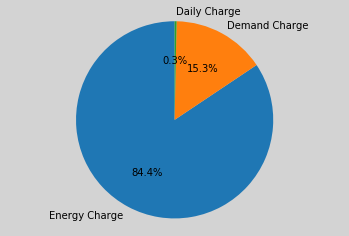

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (155, 260, 105, 31, 31, 51, 0.5499999999999999, 0.8999999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 51.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


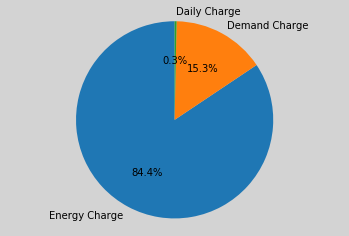

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (240, 220, 255, 16, 26, 1, 0.3, 0.7999999999999998, 0.7999999999999998)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 26.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.1612629890441895 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 1.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6660799980163574 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


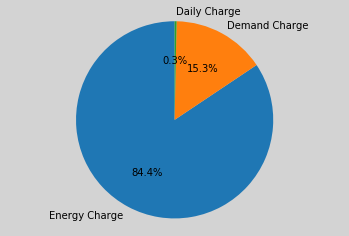

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (115, 265, 165, 56, 16, 56, 0.8499999999999999, 0.39999999999999997, 0.7)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 56.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


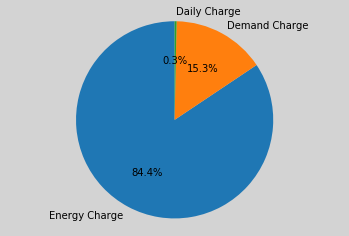

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 105, 205, 1, 31, 11, 0.7, 0.44999999999999996, 0.35)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 11.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.4491777420043945 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


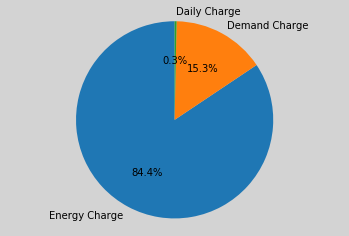

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (155, 195, 100, 51, 16, 41, 0.35, 0.3, 0.7)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


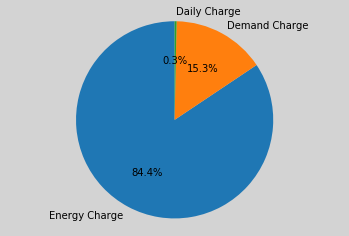

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (165, 145, 220, 41, 21, 51, 0.44999999999999996, 0.35, 0.6499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 41.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.2835307121276855 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 51.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.217124700546265 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


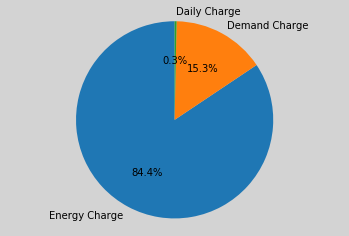

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (175, 230, 145, 51, 6, 41, 0.8499999999999999, 0.8999999999999999, 0.2)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 41.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.110975503921509 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


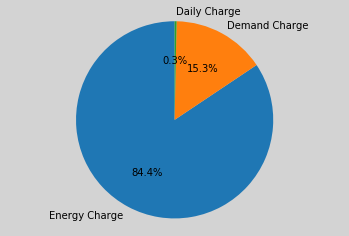

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (265, 175, 160, 26, 56, 41, 0.5999999999999999, 0.5999999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 26.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.973445415496826 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 56.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 41.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8891189098358154 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


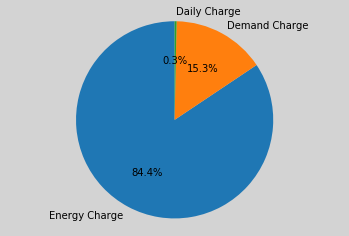

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (230, 135, 230, 56, 41, 16, 0.3, 0.44999999999999996, 0.7499999999999998)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 41.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.175220489501953 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


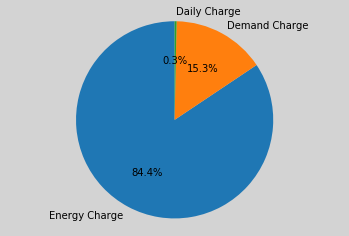

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (160, 155, 260, 1, 26, 1, 0.35, 0.39999999999999997, 0.6499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 1.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.737199306488037 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 1.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.671121120452881 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


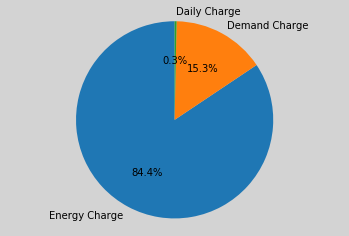

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (205, 140, 195, 56, 26, 1, 0.5999999999999999, 0.8499999999999999, 0.7)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 56.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 1.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4418530464172363 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


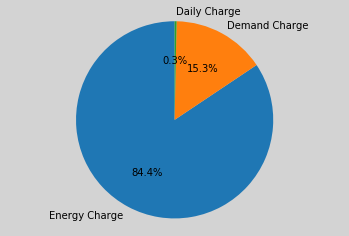

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (235, 95, 180, 41, 11, 1, 0.7999999999999998, 0.7499999999999998, 0.8499999999999999)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 41.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.09067964553833 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 1.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.432948350906372 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


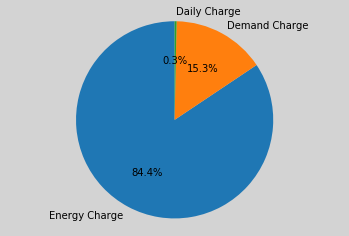

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 180, 220, 46, 56, 1, 0.7, 0.8499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 1.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4292407035827637 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


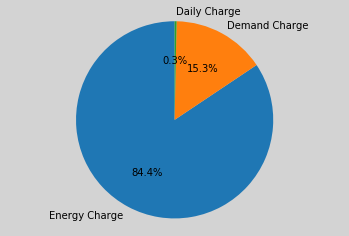

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (175, 195, 145, 26, 31, 56, 0.39999999999999997, 0.25, 0.49999999999999994)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 31.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.362689733505249 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 56.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.894031524658203 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


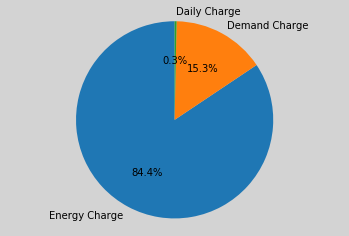

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (255, 230, 210, 31, 56, 26, 0.49999999999999994, 0.2, 0.39999999999999997)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 56.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.0536017417907715 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


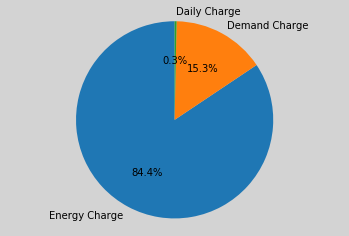

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (95, 185, 140, 1, 46, 41, 0.49999999999999994, 0.49999999999999994, 0.3)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 1.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


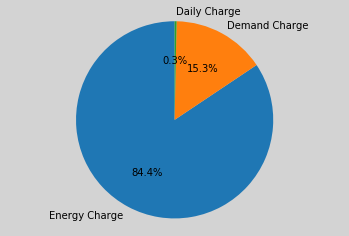

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (210, 140, 255, 31, 36, 11, 0.39999999999999997, 0.25, 0.49999999999999994)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 31.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.91766619682312 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


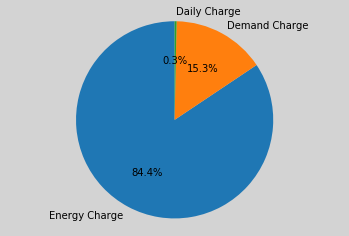

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (255, 210, 190, 26, 31, 41, 0.35, 0.7, 0.3)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


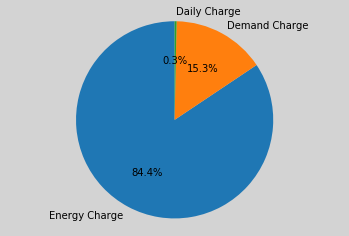

ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 400}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 400}


Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
1
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      245
azi1      180
azi2      215
tilt0      41
tilt1      56
tilt2       1
gcr0     0.55
gcr1      0.9
gcr2      0.7
Name: 0, dtype: object


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


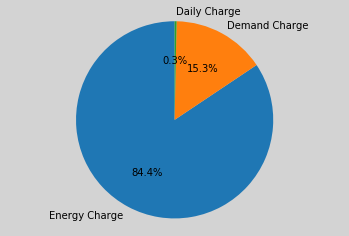

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
[[245, 180, 215, 41, 56, 1, 0.5499999999999999, 0.8999999999999999, 0.7, 30513.1, 0.0, 0.0, 0.0, 0.0, 1, 'red', {'Levelized Costs': -0.010499999998998533, 'Energy Charge': 25747.969999999998, 'Demand Charge': 4667.576, 'Daily Charge': 97.5645}, 0.0, 261136.0, 0.0]]


In [25]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_file,
                 ehub_file=ehub_file,
                 res_file=res_file,
                 pvbuilding=pvbuilding,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","SINGLE")
pvoptimizer.processGA(ga_proc)